In [1]:
import jax
print(f"JAX devices: {jax.devices()}")
print(f"Backend: {jax.default_backend()}")
assert jax.default_backend() == "gpu", "gpu not detected!"


JAX devices: [CudaDevice(id=0)]
Backend: gpu


In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit

import jaxley as jx
from jaxley.channels import Na, K, Leak
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import fully_connect, connect, sparse_connect

In [3]:
import os, json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
# load data from grads notebook! 
def load_dataset(path="/n/home12/isanchez/jaxneuro/outputs/local_phys_dataset.npz"):
    d = np.load(path)
    out = {k: d[k] for k in d.files}
    for k in ("dt", "t_max", "i_delay", "i_dur", "N_trials", "Nsyn"):
        if k in out:
            out[k] = float(out[k]) if "." in str(out[k]) else int(out[k])
    return out

ds = load_dataset()

GRADS = ds["GRADS"]  # (N, Nsyn)
VLOCAL = ds["VLOCAL"]  # (N, Nsyn -1, T)
VSOMA = ds["VSOMA"]   # (N, T)
VALL = ds["VALL"]  # (N, Nsyn, T)
patterns = ds["patterns"] # (N, Nsyn)
losses = ds["losses"]  # (N,)
syn_post_comp_indices = ds["syn_post_comp_indices"]

dt = ds["dt"]
t_max = ds["t_max"]
i_delay = ds["i_delay"]
i_dur = ds["i_dur"]

N, Nsyn = GRADS.shape
T = VALL.shape[2]

# time axis
t = np.arange(T) * dt  # (T,)

# stimulus boolean mask
t_stim = (t >= i_delay) & (t <= i_delay + i_dur)


print(f"GRADS: {GRADS.shape}")
print(f"VLOCAL: {VLOCAL.shape}")
print(f"VSOMA: {VSOMA.shape}")
print(f"VALL: {VALL.shape}")
print(f"patterns:{patterns.shape}")
print(f"losses: {losses.shape}")
print(f"\n dt={dt} ms, t_max={t_max} ms,T={T} timepoints")
print(f"i_delay={i_delay} ms,i_dur={i_dur} ms")
print(f"stimulus window: {t_stim.sum()} timepoints "
      f"({t[t_stim][0]:.3f}–{t[t_stim][-1]:.3f} ms)")
print(f" N_trials={N},  Nsyn={Nsyn}")
print(f"syn_post_comp_indices = {syn_post_comp_indices}")

assert GRADS.shape == (N, Nsyn)
assert VLOCAL.shape == (N, Nsyn -1, T)
assert VSOMA.shape  == (N, T)
assert VALL.shape == (N, Nsyn, T)
print("\nAll shape checks passed!!!")


GRADS: (500, 8)
VLOCAL: (500, 7, 2002)
VSOMA: (500, 2002)
VALL: (500, 8, 2002)
patterns:(500, 8)
losses: (500,)

 dt=0.025 ms, t_max=50.0 ms,T=2002 timepoints
i_delay=3.0 ms,i_dur=2.0 ms
stimulus window: 81 timepoints (3.000–5.000 ms)
 N_trials=500,  Nsyn=8
syn_post_comp_indices = [ 0  2  4  6  8 10 12 14]

All shape checks passed!!!


## Step 7a: time correlation map

At each timepoint t and for each synapse, we can compute the Pearson correlation (across trials n) between a local signal $x_{n,i}(t)$ and the scalar gradient $g_{n,i}$ so that we have 

$$r_i(t) = \text{corr}_n\!\big(x_{n,i}(t),\; g_{n,i}\big)$$

and then aggregate $\overline{r^2}(t) = \text{mean}_i\, r_i(t)^2$


Becuase I have v_soma and v_local, I can compute the correlation with the gradient of v_local. And separetly do v_soma? Or does it make more sense to do all at once? 

In [5]:
def time_resolved_corr(signal, grads):
    N, Nsyn, T = signal.shape
    assert grads.shape == (N, Nsyn), f"Expected grads {(N, Nsyn)}, got {grads.shape}"

    r_by_syn = np.zeros((Nsyn, T))
    for i in range(Nsyn):
        g_i = grads[:, i] # in R^N
        # vectorised pearson r across all timepoints at once
        # signal[:, i, :] is (N, T) — correlate each column with g_i
        x = signal[:, i, :]  # in R^N
        # demean
        x_dm = x - x.mean(axis=0, keepdims=True)
        g_dm = g_i - g_i.mean()
        num = (x_dm * g_dm[:, None]).sum(axis=0)          # (T,)
        denom = np.sqrt((x_dm**2).sum(axis=0) * (g_dm**2).sum()) + 1e-30 # want to prevent division by zero 
        r_by_syn[i] = num / denom # (Nsyn, T)
    return r_by_syn


r_v_all = time_resolved_corr(VALL, GRADS) # (Nsyn, T)
mean_r2_v_all = (r_v_all**2).mean(axis=0)  # (T,)
mean_r_v_all = r_v_all.mean(axis=0) # (T,)


## look at changes in voltage? 
dVdt = np.gradient(VALL, dt, axis=2)  # (N, Nsyn, T)
r_dvdt = time_resolved_corr(dVdt, GRADS)  # (Nsyn, T)
mean_r2_dvdt = (r_dvdt**2).mean(axis=0) # (T,)
mean_r_dvdt = r_dvdt.mean(axis=0) # (T,)

print(f"r_v_all shape: {r_v_all.shape}")
print(f"mean_r2_v_all shape: {mean_r2_v_all.shape}")
print(f"r_dvdt shape: {r_dvdt.shape}")
print(f"mean_r2_dvdt shape: {mean_r2_dvdt.shape}")


r_v_all shape: (8, 2002)
mean_r2_v_all shape: (2002,)
r_dvdt shape: (8, 2002)
mean_r2_dvdt shape: (2002,)


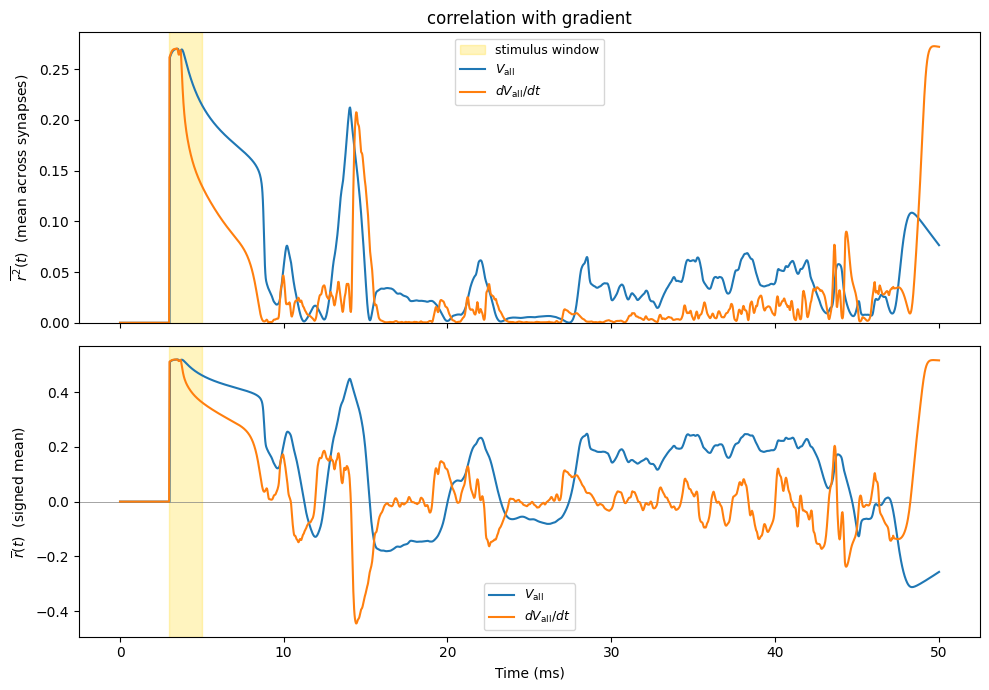

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

ax = axes[0]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25, label="stimulus window")
ax.plot(t, mean_r2_v_all, label=r"$V_{\rm all}$", lw=1.5)
ax.plot(t, mean_r2_dvdt,   label=r"$dV_{\rm all}/dt$", lw=1.5)
ax.set_ylabel(r"$\overline{r^2}(t)$  (mean across synapses)")
ax.set_title("correlation with gradient")
ax.legend(fontsize=9)
ax.set_ylim(bottom=0)

ax = axes[1]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25)
ax.axhline(0, color="grey", lw=0.5)
ax.plot(t, mean_r_v_all, label=r"$V_{\rm all}$", lw=1.5)
ax.plot(t, mean_r_dvdt,   label=r"$dV_{\rm all}/dt$", lw=1.5)
ax.set_ylabel(r"$\overline{r}(t)$  (signed mean)")
ax.set_xlabel("Time (ms)")
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()


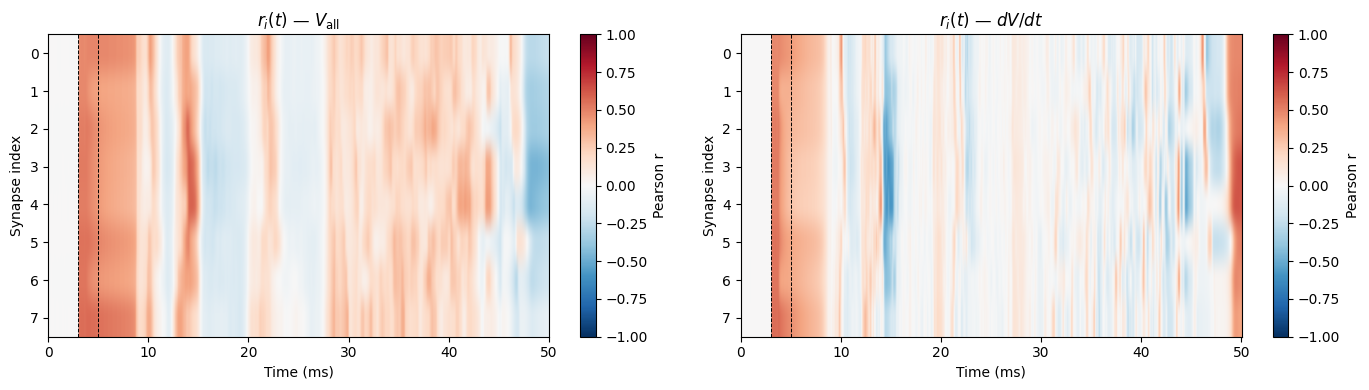

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for ax, data, title in zip(
    axes,
    [r_v_all, r_dvdt],
    [r"$r_i(t)$ — $V_{\rm all}$", r"$r_i(t)$ — $dV/dt$"],
):
    im = ax.imshow(
        data,
        aspect="auto",
        cmap="RdBu_r",
        vmin=-1, vmax=1,
        extent=[t[0], t[-1], Nsyn - 0.5, - 0.5],
    )
    ax.axvline(i_delay, color="k", ls="--", lw=0.7)
    ax.axvline(i_delay + i_dur, color="k", ls="--", lw=0.7)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Synapse index")
    ax.set_title(title)
    plt.colorbar(im, ax=ax, label="Pearson r")

plt.tight_layout()
plt.show()

So far just seems to be the case that the strongest possible predictive time is really early like near stimulus onset(or like the initial polarization)

also seems to be something happening later on, but not sure how to quantify? maybe more spiking/bAP? 


synapse specific credits vs global effect? I wonder if this is where you do off vs on diagonals? how to zone inmore to bap times etc

## Step 7b — Conditional correlation (ON vs OFF)

For each synapse $i$ and time $t$:

- pooled (computed above): $r_i(t) = \text{corr}(V_i(t), g_i)$ across all trials
- conditional ON: $r_i^{\text{on}}(t) = \text{corr}(V_i(t), g_i \mid p_i = 1)$
- conditional OFF: $r_i^{\text{off}}(t) = \text{corr}(V_i(t), g_i \mid p_i = 0)$


In [8]:
print("ON/OFF trial counts per synapse") # expect N/2 ON and N/2 OFF trials per synapse
on_counts = patterns.sum(axis=0).astype(int)   # (Nsyn,)
off_counts = N - on_counts
for i in range(Nsyn):
    print(f"synapse {i}: ON = {on_counts[i]:4d}, OFF = {off_counts[i]:4d}")

ON/OFF trial counts per synapse
synapse 0: ON =  238, OFF =  262
synapse 1: ON =  234, OFF =  266
synapse 2: ON =  248, OFF =  252
synapse 3: ON =  268, OFF =  232
synapse 4: ON =  237, OFF =  263
synapse 5: ON =  250, OFF =  250
synapse 6: ON =  237, OFF =  263
synapse 7: ON =  228, OFF =  272


In [9]:
def corr_1d(x, y, eps=1e-12):
    x = x - x.mean()
    y = y - y.mean()
    denom = np.sqrt((x @ x) * (y @ y)) + eps
    return (x @ y) / denom


def timecorr_conditional(VALL, GRADS, patterns, min_trials=20):
    N, Nsyn, T = VALL.shape
    r_on = np.full((Nsyn, T), np.nan)
    r_off = np.full((Nsyn, T), np.nan)

    for i in range(Nsyn):
        m_on = patterns[:, i].astype(bool)
        m_off = ~m_on

        # ON
        if m_on.sum() >= min_trials:
            y = GRADS[m_on, i]           # (N_on,)
            X = VALL[m_on, i, :]         # (N_on, T)
            # vectorised across time
            X_dm = X - X.mean(axis=0, keepdims=True)
            y_dm = y - y.mean()
            num = (X_dm * y_dm[:, None]).sum(axis=0)                     # (T,)
            denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + 1e-12
            r_on[i] = num / denom

        # OFF
        if m_off.sum() >= min_trials:
            y = GRADS[m_off, i]
            X = VALL[m_off, i, :]
            X_dm = X - X.mean(axis=0, keepdims=True)
            y_dm = y - y.mean()
            num = (X_dm * y_dm[:, None]).sum(axis=0)
            denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + 1e-12
            r_off[i] = num / denom

    return r_on, r_off


# conditional correlation
r_on, r_off = timecorr_conditional(VALL, GRADS, patterns)
print(f"r_on  shape: {r_on.shape},  finite: {np.isfinite(r_on).sum()}/{r_on.size}")
print(f"r_off shape: {r_off.shape},  finite: {np.isfinite(r_off).sum()}/{r_off.size}")

# also do dV/dt
r_on_dvdt, r_off_dvdt = timecorr_conditional(dVdt, GRADS, patterns)
print(f"r_on_dvdt  shape: {r_on_dvdt.shape}")
print(f"r_off_dvdt shape: {r_off_dvdt.shape}")


r_on  shape: (8, 2002),  finite: 16016/16016
r_off shape: (8, 2002),  finite: 16016/16016
r_on_dvdt  shape: (8, 2002)
r_off_dvdt shape: (8, 2002)


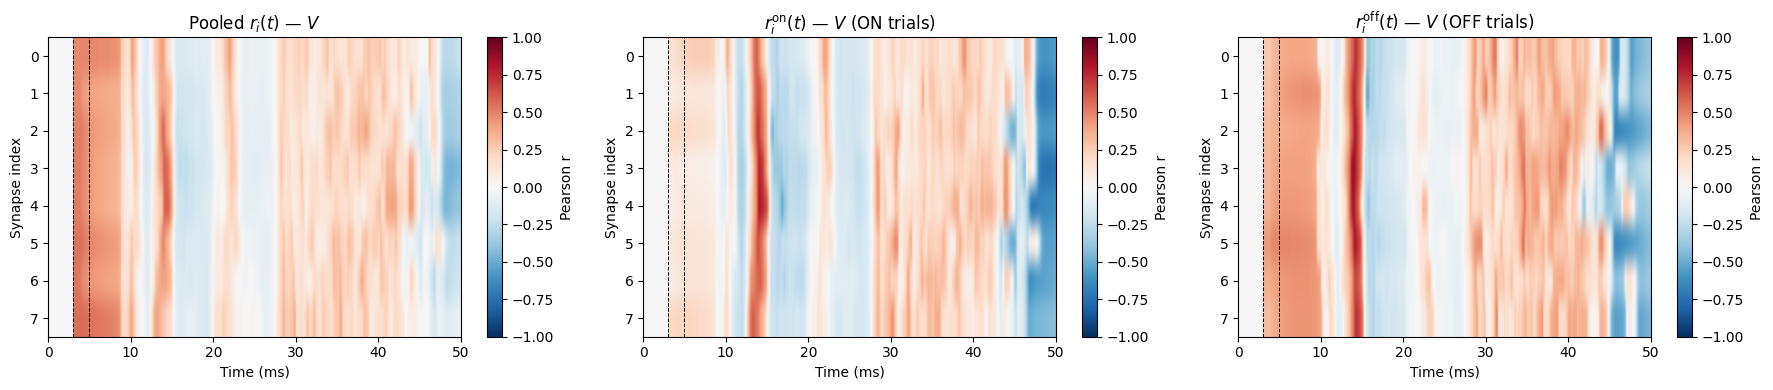

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for ax, data, title in zip(
    axes,
    [r_v_all, r_on, r_off],
    [r"Pooled $r_i(t)$ — $V$",
     r"$r_i^{\mathrm{on}}(t)$ — $V$ (ON trials)",
     r"$r_i^{\mathrm{off}}(t)$ — $V$ (OFF trials)"],
):
    im = ax.imshow(
        data, aspect="auto", cmap="RdBu_r",
        vmin=-1, vmax=1,
        extent=[t[0], t[-1], Nsyn - 0.5, -0.5],
    )
    ax.axvline(i_delay, color="k", ls="--", lw=0.7)
    ax.axvline(i_delay + i_dur, color="k", ls="--", lw=0.7)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Synapse index")
    ax.set_title(title)
    plt.colorbar(im, ax=ax, label="Pearson r")

plt.tight_layout()
plt.show()


This may be a sign of global effects dominating. We are getting high r at 35ish ms even in the OFF condition. So it may be that the voltage at many sites/synapses is dominated by a shared postsynaptic event (spike/bAP/?) and the g_i covaries with these events because the loss is based on the somatic trace only. Also, the heatmaps look like vertical bands (similar timing across synapses) rather than very synapse specific timing so again hinting at some global effect.

We can check if g_i is actually varying in OFF trials. If gradients are near constant in OFF and we are correlating against tiny variance, correlations can become unstable. We can look at STD, if STDN grad OFF is non trivial, the OFF signal might be real (resynaptic OFF neurons still spike sometimes, or synapse i still has some effect). If it’s tiny, we have to treat OFF correlations with care and think about global effects. 

In [11]:
for i in range(8):
    m_on = patterns[:, i].astype(bool)
    m_off = ~m_on
    print(i,
          "std grad ON", GRADS[m_on, i].std(),
          "std grad OFF", GRADS[m_off, i].std(),
          "mean|grad| ON", np.mean(np.abs(GRADS[m_on, i])),
          "mean|grad| OFF", np.mean(np.abs(GRADS[m_off, i])))


0 std grad ON 41420948.82376145 std grad OFF 8435877.048633358 mean|grad| ON 37297858.37378704 mean|grad| OFF 6438556.610164828
1 std grad ON 46257580.860033415 std grad OFF 6586869.787267576 mean|grad| ON 40183559.4060495 mean|grad| OFF 5685748.5553870145
2 std grad ON 38306849.28032289 std grad OFF 7644468.160623304 mean|grad| ON 36822092.64389377 mean|grad| OFF 5798088.068540127
3 std grad ON 37564897.987522244 std grad OFF 6828928.651050018 mean|grad| ON 38449248.255827814 mean|grad| OFF 4940361.683175011
4 std grad ON 37775477.86334822 std grad OFF 7019203.857488549 mean|grad| ON 36987752.017384276 mean|grad| OFF 5622709.020780585
5 std grad ON 31329599.65715081 std grad OFF 8707634.898668356 mean|grad| ON 34936780.143839754 mean|grad| OFF 6190909.514545146
6 std grad ON 42353118.140287496 std grad OFF 6803945.0242616525 mean|grad| ON 42389478.41223138 mean|grad| OFF 5258241.768021543
7 std grad ON 40397424.13724152 std grad OFF 7856761.0482214345 mean|grad| ON 41884444.26933363 m

In [12]:
for i in range(8):
    m_off = ~patterns[:, i].astype(bool)
    vals = np.abs(GRADS[m_off, i])
    print(i, np.percentile(vals, [50, 90, 99]))


0 [ 2798119.65162156 18319904.83954721 39661009.59429071]
1 [ 3306552.39354592 14906386.01709909 27512516.05059019]
2 [ 2882120.2612282  16168461.68351891 34774218.50674804]
3 [ 2801149.33750413 15184887.19890116 30454017.90535722]
4 [ 2974406.89434403 19838026.88144574 23842131.0502656 ]
5 [ 2309317.74946061 19272691.7626405  36153402.75332677]
6 [ 2520158.79844158 17250669.1727121  27002621.65215296]
7 [ 2576779.85744941 18336927.78551225 30777146.11984849]


## Part 7C — Partial correlation controlling for the pattern

For each synapse $i$, time $t$:
1. Regress gradient out of patterns: $g_i \approx \beta^\top P$
2. Regress voltage out of patterns: $V_i(t) \approx \gamma(t)^\top P$
3. Correlate residuals: $r_i^{\text{partial}}(t) = \text{corr}(V_i(t) - \hat{V}_i(t),\; g_i - \hat{g}_i)$

In [13]:
# ordinary least squares regression of X on P 
# subtract the part of X that is explained by P!!!
def residualize_against_P(X, P):
    beta, *_ = np.linalg.lstsq(P, X, rcond=None)   # (K,) or (K, T)
    return X - P @ beta


def partial_timecorr(VALL, GRADS, patterns, add_hamming_weight=False):
    N, Nsyn, T = VALL.shape
    cols = [np.ones((N, 1)), patterns.astype(float)]
    if add_hamming_weight:
        cols.append(patterns.sum(axis=1, keepdims=True).astype(float)) # sum how many were ON for given pattern 
    P = np.concatenate(cols, axis=1)   # (N, K)
    print(f"Design matrix P shape: {P.shape} (K = {P.shape[1]})")

    r_partial = np.full((Nsyn, T), np.nan)
    for i in range(Nsyn):
        y_res = residualize_against_P(GRADS[:, i].astype(float), P)   # (N,)
        X_res = residualize_against_P(VALL[:, i, :].astype(float), P) # (N, T)
        # vectorised correlation across time
        X_dm = X_res - X_res.mean(axis=0, keepdims=True)
        y_dm = y_res - y_res.mean()
        num   = (X_dm * y_dm[:, None]).sum(axis=0)
        denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + 1e-12
        r_partial[i] = num / denom

    return r_partial

print("Partial correlation (P = [1, patterns]):")
r_partial = partial_timecorr(VALL, GRADS, patterns, add_hamming_weight=False)
print(f" r_partial shape: {r_partial.shape}")

print("\nPartial correlation (P = [1, patterns, Hamming weight]):")
r_partial_hw = partial_timecorr(VALL, GRADS, patterns, add_hamming_weight=False)
print(f"r_partial_hw shape: {r_partial_hw.shape}")

# dV/dt versions
print("\nPartial correlation on dV/dt:")
r_partial_dvdt = partial_timecorr(dVdt, GRADS, patterns, add_hamming_weight=False)
print(f" r_partial_dvdt shape: {r_partial_dvdt.shape}")


Partial correlation (P = [1, patterns]):
Design matrix P shape: (500, 9) (K = 9)
 r_partial shape: (8, 2002)

Partial correlation (P = [1, patterns, Hamming weight]):
Design matrix P shape: (500, 9) (K = 9)
r_partial_hw shape: (8, 2002)

Partial correlation on dV/dt:
Design matrix P shape: (500, 9) (K = 9)
 r_partial_dvdt shape: (8, 2002)


In [14]:
# ON 
def partial_timecorr_on(VALL, GRADS, patterns, min_trials=20):
    N, Nsyn, T = VALL.shape
    r_partial_on = np.full((Nsyn, T), np.nan)

    for i in range(Nsyn):
        m = patterns[:, i].astype(bool)
        n_on = m.sum()
        if n_on < min_trials:
            print(f"synapse {i}: skipped (only {n_on} ON trials)")
            continue
        mask_other = np.ones(Nsyn, dtype=bool)
        mask_other[i] = False

        P = np.concatenate([
            np.ones((n_on, 1)), patterns[m][:, mask_other].astype(float)],axis=1)  # (n_on, 1 + (Nsyn-1))

        y_res = residualize_against_P(GRADS[m, i].astype(float), P)
        X_res = residualize_against_P(VALL[m, i, :].astype(float), P)

        X_dm = X_res - X_res.mean(axis=0, keepdims=True)
        y_dm = y_res - y_res.mean()
        num   = (X_dm * y_dm[:, None]).sum(axis=0)
        denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + 1e-12
        r_partial_on[i] = num / denom

    return r_partial_on

def partial_timecorr_off(VALL, GRADS, patterns, min_trials=20):
    N, Nsyn, T = VALL.shape
    r_partial_off = np.full((Nsyn, T), np.nan)

    for i in range(Nsyn):
        m = ~patterns[:, i].astype(bool)   # OFF trials for synapse i
        n_off = m.sum()
        if n_off < min_trials:
            continue

        # regress out OTHER synapses' bits (drop i)
        mask_other = np.ones(Nsyn, dtype=bool)
        mask_other[i] = False
        P = np.concatenate(
            [np.ones((n_off, 1)), patterns[m][:, mask_other].astype(float)],
            axis=1
        )

        y_res = residualize_against_P(GRADS[m, i].astype(float), P)
        X_res = residualize_against_P(VALL[m, i, :].astype(float), P)

        X_dm = X_res - X_res.mean(axis=0, keepdims=True)
        y_dm = y_res - y_res.mean()
        num   = (X_dm * y_dm[:, None]).sum(axis=0)
        denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + 1e-12
        r_partial_off[i] = num / denom

    return r_partial_off



r_partial_on = partial_timecorr_on(VALL, GRADS, patterns)
print(f"r_partial_on shape: {r_partial_on.shape}")

r_partial_off = partial_timecorr_off(VALL, GRADS, patterns)
print(f"r_partial_off shape: {r_partial_off.shape}")

r_partial_off_dvdt = partial_timecorr(dVdt, GRADS, patterns)
print(f" r_partial__off_dvdt shape: {r_partial_off_dvdt.shape}")

r_partial_on_dvdt = partial_timecorr_on(dVdt, GRADS, patterns)
print(f"r_partial_on_dvdt shape: {r_partial_on_dvdt.shape}")


r_partial_on shape: (8, 2002)
r_partial_off shape: (8, 2002)
Design matrix P shape: (500, 9) (K = 9)
 r_partial__off_dvdt shape: (8, 2002)
r_partial_on_dvdt shape: (8, 2002)


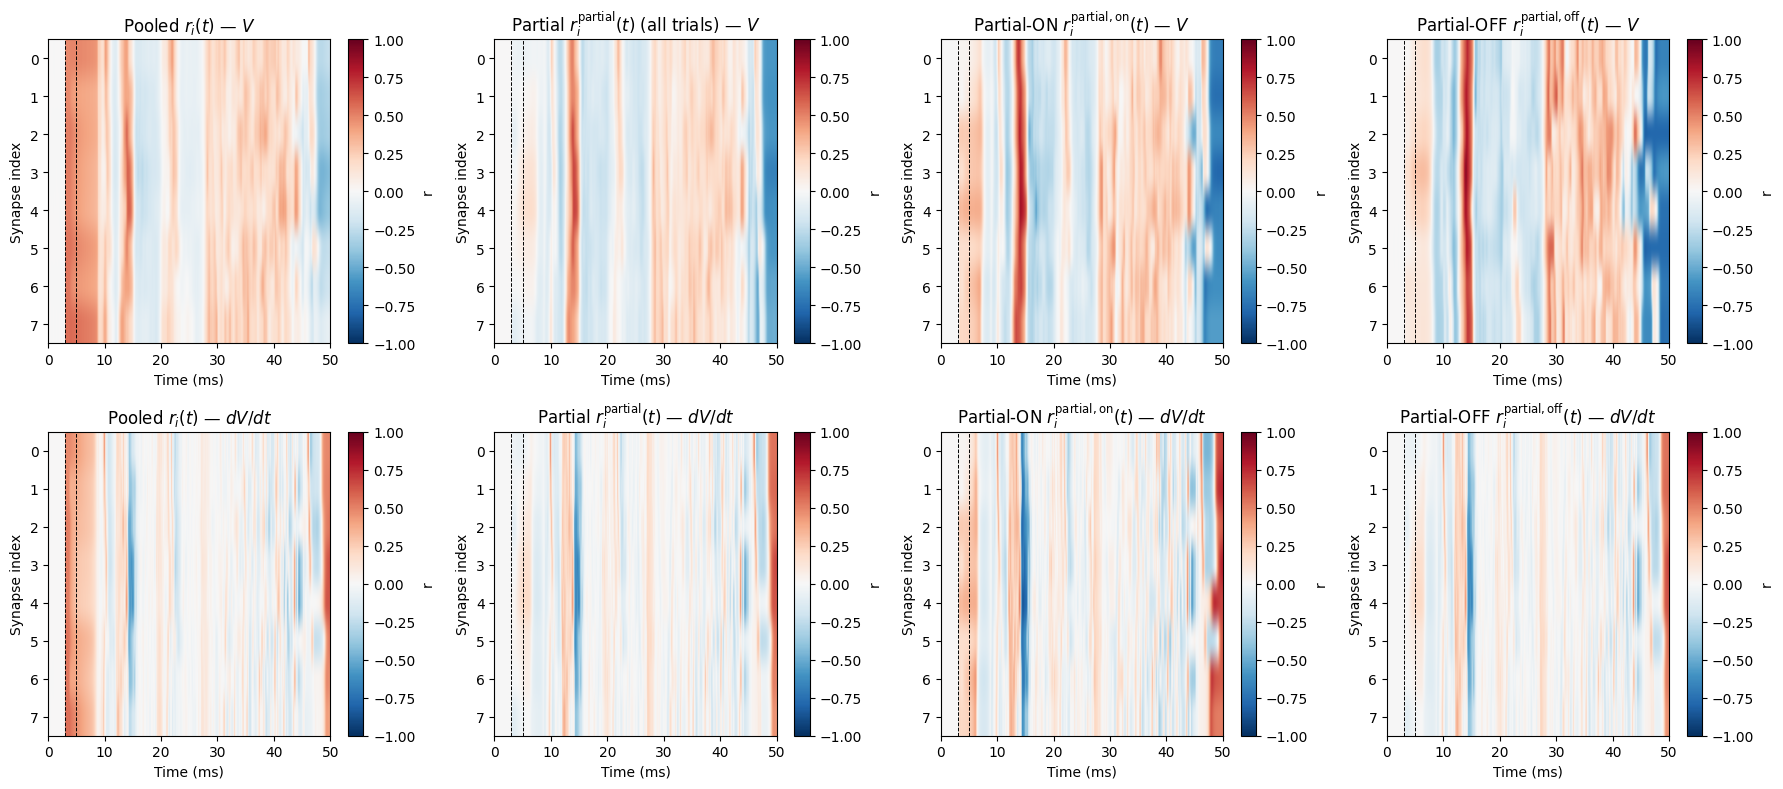

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(18, 8))

# V
titles_top = [
    r"Pooled $r_i(t)$",
    r"Partial $r_i^{\mathrm{partial}}(t)$ (all trials)",
    r"Partial-ON $r_i^{\mathrm{partial,on}}(t)$",
    r"Partial-OFF $r_i^{\mathrm{partial,off}}(t)$",
]
datas_top = [r_v_all, r_partial, r_partial_on, r_partial_off]

for ax, data, title in zip(axes[0], datas_top, titles_top):
    im = ax.imshow(
        data, aspect="auto", cmap="RdBu_r",
        vmin=-1, vmax=1,
        extent=[t[0], t[-1], Nsyn - 0.5, -0.5],
    )
    ax.axvline(i_delay, color="k", ls="--", lw=0.7)
    ax.axvline(i_delay + i_dur, color="k", ls="--", lw=0.7)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Synapse index")
    ax.set_title(title + " — $V$")
    plt.colorbar(im, ax=ax, label="r")

# dVdt
titles_bot = [
    r"Pooled $r_i(t)$",
    r"Partial $r_i^{\mathrm{partial}}(t)$",
    r"Partial-ON $r_i^{\mathrm{partial,on}}(t)$",
    r"Partial-OFF $r_i^{\mathrm{partial,off}}(t)$",
]
datas_bot = [r_dvdt, r_partial_dvdt, r_partial_on_dvdt, r_partial_off_dvdt]

for ax, data, title in zip(axes[1], datas_bot, titles_bot):
    im = ax.imshow(
        data, aspect="auto", cmap="RdBu_r",
        vmin=-1, vmax=1,
        extent=[t[0], t[-1], Nsyn - 0.5, -0.5],
    )
    ax.axvline(i_delay, color="k", ls="--", lw=0.7)
    ax.axvline(i_delay + i_dur, color="k", ls="--", lw=0.7)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Synapse index")
    ax.set_title(title + " — $dV/dt$")
    plt.colorbar(im, ax=ax, label="r")

plt.tight_layout()
plt.show()


## Step 7d — Full cross-correlation matrix $R_{i,j}(t)$

$$R_{i,j}(t) = \operatorname{corr}_{\text{trials}}\!\big(V_j(t),\; g_i\big)$$

In [16]:
def crosscorr_time(VALL, GRADS, eps=1e-12):
    N, J, T = VALL.shape
    I = GRADS.shape[1]

    Y = GRADS - GRADS.mean(axis=0, keepdims=True)    # (N, I)
    X = VALL  - VALL.mean(axis=0, keepdims=True)      # (N, J, T)

    num = np.einsum("ni,njt->ijt", Y, X)              # (I, J, T)
    sy  = np.sqrt((Y**2).sum(axis=0)) + eps           # (I,)
    sx  = np.sqrt((X**2).sum(axis=0)) + eps           # (J, T)

    R = num / (sy[:, None, None] * sx[None, :, :])    # (I, J, T)
    return R


R_cross = crosscorr_time(VALL, GRADS)
print(f"R_cross shape: {R_cross.shape}")  # (8, 8, 2002)

# dV/dt
R_cross_dvdt = crosscorr_time(dVdt, GRADS)
print(f"R_cross_dvdt shape: {R_cross_dvdt.shape}")


R_cross shape: (8, 8, 2002)
R_cross_dvdt shape: (8, 8, 2002)


In [18]:
def diag_off_summary(R):
    I, J, T = R.shape
    assert I == J, "R must be square in first two dims"

    diag = np.array([R[i, i, :] for i in range(I)])       # (I, T)
    flat = R.reshape(I * J, T)
    off_mask = np.ones(I * J, dtype=bool)
    off_mask[np.arange(I) * J + np.arange(I)] = False
    off = flat[off_mask]                                   # (I*J - I, T)

    diag_m = (diag**2).mean(axis=0)                        # (T,)
    off_m  = (off**2).mean(axis=0)                         # (T,)
    ratio  = diag_m / (off_m + 1e-12)
    return diag_m, off_m, ratio


diag_m, off_m, ratio = diag_off_summary(R_cross)
diag_m_dv, off_m_dv, ratio_dv = diag_off_summary(R_cross_dvdt)


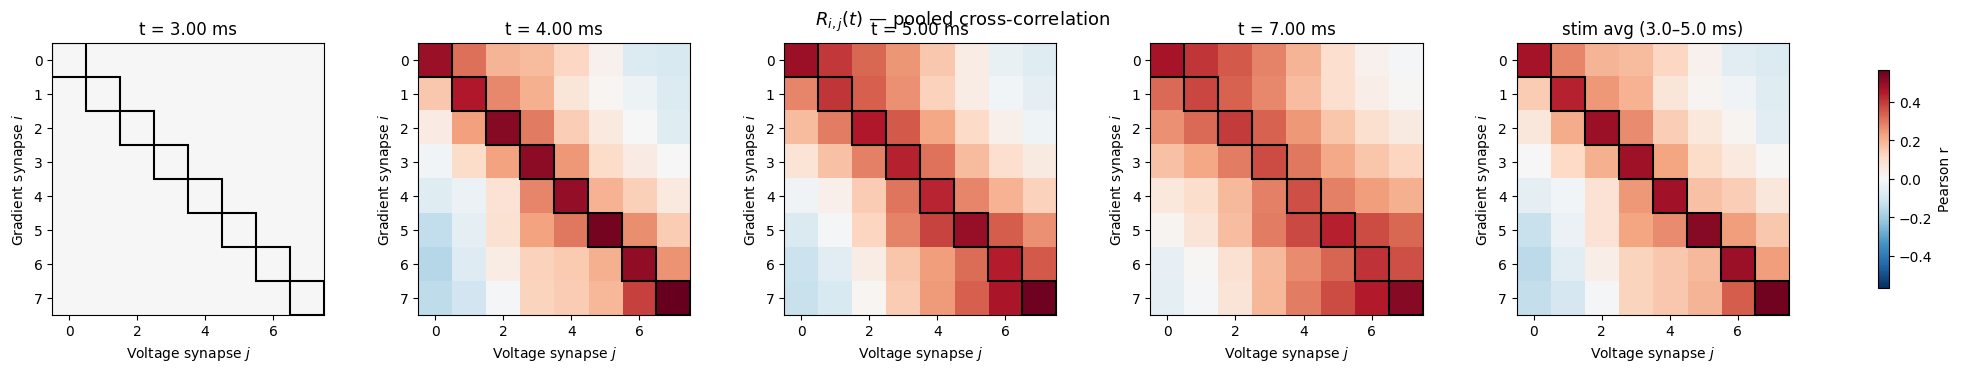

In [19]:
t_snap_ms = [i_delay, i_delay + i_dur / 2, i_delay + i_dur, i_delay + i_dur + 2]
t_snap_idx = [np.argmin(np.abs(t - ts)) for ts in t_snap_ms]

# stimulus window average
R_stim_avg = R_cross[:, :, t_stim].mean(axis=2)   # (I, J)

n_panels = len(t_snap_idx) + 1  # snapshots + stim average
fig, axes = plt.subplots(1, n_panels, figsize=(4 * n_panels, 3.5),
                         constrained_layout=True)

vmax = np.max(np.abs(R_cross[:, :, t_stim]))  # adaptive color scale

for k, (ax, tidx) in enumerate(zip(axes[:-1], t_snap_idx)):
    im = ax.imshow(R_cross[:, :, tidx], cmap="RdBu_r", vmin=-vmax, vmax=vmax)
    ax.set_title(f"t = {t[tidx]:.2f} ms")
    ax.set_xlabel("Voltage synapse $j$")
    ax.set_ylabel("Gradient synapse $i$")
    # highlight diagonal
    for d in range(Nsyn):
        ax.add_patch(plt.Rectangle((d - 0.5, d - 0.5), 1, 1,
                                    fill=False, ec="k", lw=1.5))

# stimulus window average
ax = axes[-1]
im = ax.imshow(R_stim_avg, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
ax.set_title(f"stim avg ({i_delay}–{i_delay+i_dur} ms)")
ax.set_xlabel("Voltage synapse $j$")
ax.set_ylabel("Gradient synapse $i$")
for d in range(Nsyn):
    ax.add_patch(plt.Rectangle((d - 0.5, d - 0.5), 1, 1,
                                fill=False, ec="k", lw=1.5))

plt.colorbar(im, ax=axes.tolist(), label="Pearson r", shrink=0.8)
fig.suptitle(r"$R_{i,j}(t)$ — pooled cross-correlation", fontsize=13, y=1.02)
plt.show()


4–7 ms and stim avg show strong diagonal but also strong near diagonal/off-diagonal structure.
So there must be some local component but still a structured global component

In [ ]:
tidx = np.argmin(np.abs(t - 3.0))
print("snapshot time:", t[tidx])

print("max|R| at 3ms:", np.max(np.abs(R_cross[:, :, tidx])))

for j in range(Nsyn):
    print(j, "std V_j at 3ms:", np.std(VALL[:, j, tidx]))


snapshot time: 3.0
max|R| at 3ms: 6.737874306554396e-16
0 std V_j at 3ms: 0.0
1 std V_j at 3ms: 0.0
2 std V_j at 3ms: 1.4210854715202004e-14
3 std V_j at 3ms: 1.4210854715202004e-14
4 std V_j at 3ms: 1.4210854715202004e-14
5 std V_j at 3ms: 0.0
6 std V_j at 3ms: 1.4210854715202004e-14
7 std V_j at 3ms: 1.4210854715202004e-14


## Step 2 — Partial-ON cross-correlation matrix $R_{i,j}^{\text{partial,on}}(t)$

For each gradient synapse $i$:
1. Restrict to ON trials for synapse $i$
2. Residualize $g_i$ and every $V_j(t)$ against pattern bits
3. Compute $R_{i,j}^{\text{partial,on}}(t) = \operatorname{corr}(\text{resid}(V_j(t)),\; \text{resid}(g_i))$

This is the strongest test: does local voltage at synapse $j$ explain the gradient at synapse $i$, within ON trials and beyond pattern context?


In [20]:
def crosscorr_partial_on(VALL, GRADS, patterns, min_trials=20, eps=1e-12):
    N, J, T = VALL.shape
    I = GRADS.shape[1]
    R_partial_on = np.full((I, J, T), np.nan)

    for i in range(I):
        m = patterns[:, i].astype(bool)
        n_on = m.sum()
        if n_on < min_trials:
            print(f"  gradient synapse {i}: skipped ({n_on} ON trials)")
            continue

        # design matrix: intercept + other pattern bits
        mask_other = np.ones(I, dtype=bool)
        mask_other[i] = False
        P = np.concatenate([
            np.ones((n_on, 1)),
            patterns[m][:, mask_other].astype(float)
        ], axis=1)  # (n_on, 1 + (Nsyn-1))

        # residualize gradient
        y_res = residualize_against_P(GRADS[m, i].astype(float), P)  # (n_on,)
        y_dm  = y_res - y_res.mean()

        for j in range(J):
            # residualize voltage at synapse j
            X_res = residualize_against_P(VALL[m, j, :].astype(float), P)  # (n_on, T)
            X_dm  = X_res - X_res.mean(axis=0, keepdims=True)

            num   = (X_dm * y_dm[:, None]).sum(axis=0)                     # (T,)
            denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + eps
            R_partial_on[i, j, :] = num / denom

    return R_partial_on


R_partial_on_cross = crosscorr_partial_on(VALL, GRADS, patterns)
print(f"R_partial_on_cross shape: {R_partial_on_cross.shape}")  # (8, 8, 2002)


R_partial_on_cross shape: (8, 8, 2002)


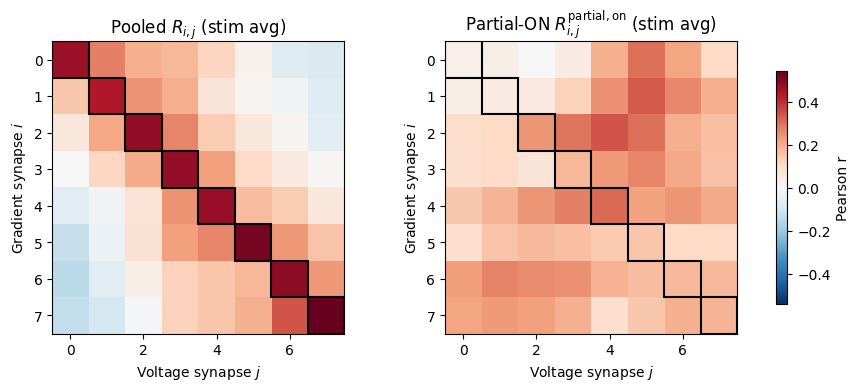

In [21]:
R_po_stim_avg = np.nanmean(R_partial_on_cross[:, :, t_stim], axis=2)  # (I, J)

fig, axes = plt.subplots(1, 2, figsize=(9, 3.8),
                         constrained_layout=True)

vmax2 = max(np.nanmax(np.abs(R_stim_avg)),
            np.nanmax(np.abs(R_po_stim_avg)))

for ax, mat, title in zip(
    axes,
    [R_stim_avg, R_po_stim_avg],
    [r"Pooled $R_{i,j}$ (stim avg)",
     r"Partial-ON $R_{i,j}^{\mathrm{partial,on}}$ (stim avg)"],
):
    im = ax.imshow(mat, cmap="RdBu_r", vmin=-vmax2, vmax=vmax2)
    ax.set_xlabel("Voltage synapse $j$")
    ax.set_ylabel("Gradient synapse $i$")
    ax.set_title(title)
    for d in range(Nsyn):
        ax.add_patch(plt.Rectangle((d - 0.5, d - 0.5), 1, 1,
                                    fill=False, ec="k", lw=1.5))

plt.colorbar(im, ax=axes.tolist(), label="Pearson r", shrink=0.8)
plt.show()


More diffused partial ON. So some strong locality and later/shared components, and partial-ON looks more shared -> credit signals might start local but get mixed with global dendritic dynamics??

WHAT DO I DO??

## 5) Per-synapse diagonal dominance — which synapses are local vs global?

Averaging the diagonal ratio across synapses (cell 25) can hide heterogeneity.
Instead, compute per-synapse diagonal dominance:

$$\text{ratio}_i(t) = \frac{R_{i,i}(t)^2}{\frac{1}{I-1}\sum_{j \neq i} R_{i,j}(t)^2}$$

- $\text{ratio}_i(t) \gg 1$: synapse $i$'s gradient is mostly explained by its **own** local voltage → *local credit*.
- $\text{ratio}_i(t) \approx 1$: the diagonal entry is no stronger than a typical off-diagonal → *global / diffuse*.
- $\text{ratio}_i(t) < 1$: another synapse's voltage is *more* predictive than the local one.


In [ ]:
def per_synapse_diag_dominance(R, eps=1e-12):
    I, J, T = R.shape
    assert I == J, "R must be square in first two dims"

    ratio = np.zeros((I, T))
    for i in range(I):
        diag_sq = R[i, i, :] ** 2                          # (T,)
        off_sq = np.concatenate([R[i, :i, :], R[i, i+1:, :]], axis=0) ** 2  # (I-1, T)
        mean_off_sq = off_sq.mean(axis=0)                   # (T,)
        ratio[i] = diag_sq / (mean_off_sq + eps)
    return ratio

ratio_pooled = per_synapse_diag_dominance(R_cross)
print(f"ratio_pooled shape: {ratio_pooled.shape}")   # (8, 2002)

ratio_partial_on = per_synapse_diag_dominance(R_partial_on_cross)
print(f"ratio_partial_on shape: {ratio_partial_on.shape}")

ratio_dvdt = per_synapse_diag_dominance(R_cross_dvdt)
print(f"ratio_dvdt shape: {ratio_dvdt.shape}")


ratio_pooled shape: (8, 2002)
ratio_partial_on shape: (8, 2002)
ratio_dvdt shape: (8, 2002)


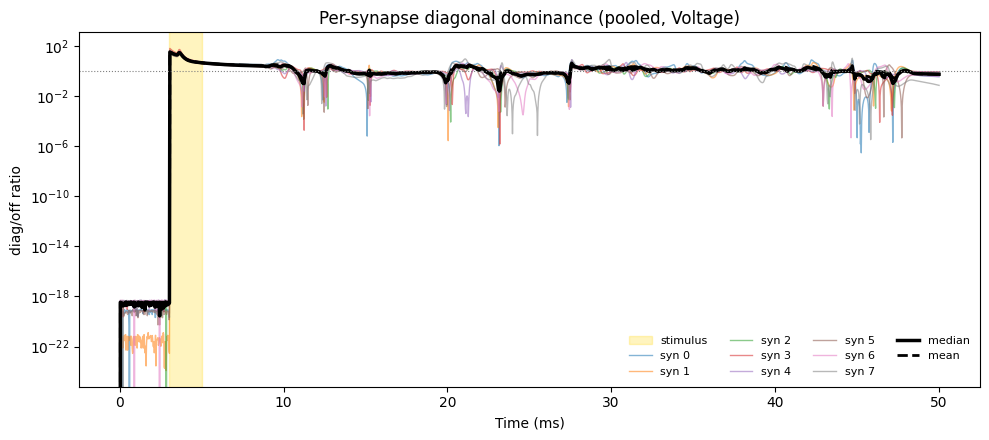

In [23]:
def plot_diag_dominance_spaghetti(t, ratios, i_delay, i_dur, title, label_prefix="syn"):
    I, T = ratios.shape

    plt.figure(figsize=(10, 4.5))
    plt.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25, label="stimulus")

    # thin lines: each synapse
    for i in range(I):
        plt.plot(t, ratios[i], lw=1.0, alpha=0.55, label=f"{label_prefix} {i}")

    # thick summary: median (more robust than mean)
    med = np.nanmedian(ratios, axis=0)
    mean = np.nanmean(ratios, axis=0)
    plt.plot(t, med, color="k", lw=2.5, label="median")
    plt.plot(t, mean, color="k", lw=2.0, ls="--", label="mean")

    plt.axhline(1, color="grey", lw=0.8, ls=":")
    plt.yscale("log")  # strongly recommended; ratios can be 1–30+
    plt.xlabel("Time (ms)")
    plt.ylabel("diag/off ratio")
    plt.title(title)
    plt.legend(ncol=4, fontsize=8, frameon=False)
    plt.tight_layout()
    plt.show()

plot_diag_dominance_spaghetti(
    t, ratio_pooled, i_delay, i_dur,
    title="Per-synapse diagonal dominance (pooled, Voltage)"
)
